# Graphing

## Setup

In [17]:
import matplotlib
import parselmouth
import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# from matplotlib.cm import ScalarMappable
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 1
%aimport graphing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Global parameters

def remove_from_list(lst, idxs):
    if type(idxs) is int:
        return [i for j, i in enumerate(lst) if j != idxs]
    else:
        return [i for j, i in enumerate(lst) if j not in idxs]
    
languages = ["AR", "BG", "CH", "CR", "CZ", "FR", "GE", "JA", "KO", "PL", 
              "PO", "RU", "SP", "SW", "TA", "TH", "TU", "WU", "VN"]
exps = ["mfcc", "mfcc-deltas", "sdc", "pitch", "energy", "pitch-energy", 
        "sdc-pitch-energy", "sdc-pitch", "sdc-energy"]

## Plotting sample prosodic features

In [5]:
def draw_spectrogram(spectrogram, ax, fig, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    X *= 100
    sg_db = 10 * np.log10(spectrogram.values)
    ax.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='Greys', figure=fig)
    plt.ylim([spectrogram.ymin, spectrogram.ymax])

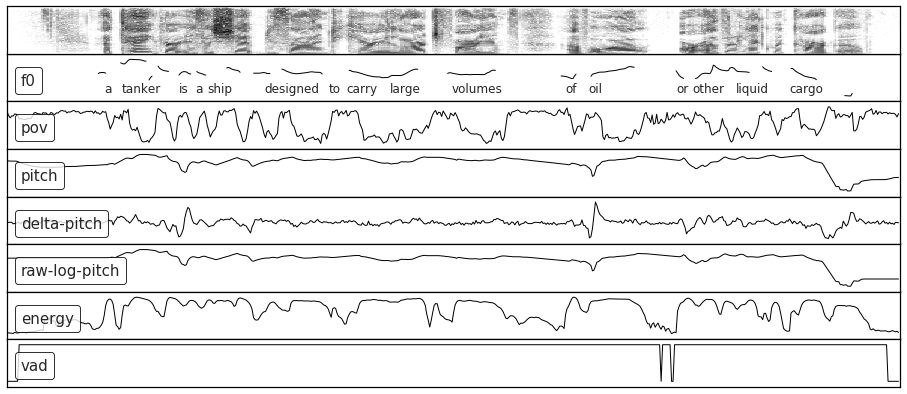

In [11]:
df = pd.read_csv("data/feats_LDC93S6A")
snd = parselmouth.Sound("data/LDC93S6A.wav")
columns = list(df.columns)
n_rows = len(columns) + 2
n_frames = df.shape[0]
colour = "black"
w = 16
v_margin = 0.15
fig, axs = plt.subplots(nrows=n_rows, ncols=1, sharex=True, sharey=False, figsize=(w, 7))
plt.subplots_adjust(hspace=0.0)

# Spectrogram
ax = graphing.insert_axis(axs[0], fig)
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.025, time_step=0.01, maximum_frequency=8000)
draw_spectrogram(spectrogram, ax, fig)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# F0
pitch = snd.to_pitch_ac(time_step=0.01, pitch_floor=50, pitch_ceiling=500.0) 
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values==0] = np.nan
data_line =[{
            "values": pitch_values,
            "xs": range(len(pitch_values)),
            "label": "f0",
            "colour": colour,
            "symbol": "."
        }]
ax = axs[1]
maximum = pitch_values[np.isnan(pitch_values) == False].max()
minimum = pitch_values[np.isnan(pitch_values) == False].min()
val_range = maximum - minimum
ymax = maximum + v_margin*val_range
ymin = minimum - v_margin*val_range
graphing.plot_linear(data_line, use_legend=True, legend_loc=3, fig=fig, drawLegendLines=False,
            ax=ax, linewidth=1.0, markersize=0, tight_layout=False, ymin=ymin, ymax=ymax)

# Prosodic features + VAD
for i, col in enumerate(columns):
    data_line =[{
            "values": df[col],
            "xs": df.index,
            "label": col,
            "colour": colour,
            "symbol": "."
        }]
    maximum = df[col].max()
    minimum = df[col].min()
    val_range = maximum - minimum
    ymax = maximum + v_margin*val_range
    ymin = minimum - v_margin*val_range
    
    ax = axs[i+2]
    fig = graphing.plot_linear(data_line, use_legend=True, legend_loc=3, fig=fig, drawLegendLines=False,
                      ax=ax, linewidth=1.0, markersize=0, tight_layout=False, ymin=ymin, ymax=ymax)
    
# Disable axis ticks
for ax in axs:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(left=0, right=n_frames)

# Word annotation
words = ["a", "tanker", "is", "a", "ship", "designed", "to", "carry", 
         "large", "volumes", "of", "oil", "or", "other", "liquid", "cargo"]
word_points = [65, 77, 115, 126, 134, 172, 215, 227, 256, 298, 374, 389, 448, 459, 488, 524]
for word, x in zip(words, word_points):
    axs[1].text(x, 100, word, fontsize=12)

plt.show()
graphing.save_fig(fig, name="prosody_sample")

## Comparing experiments

In [12]:
prosody_colours = {"none": "black", "pitch": "coral", "energy": "brown", "pitch+energy": "teal", "pitch_energy": "indigo"}
prosodic_order = ["none", "pitch", "energy", "pitch+energy", "pitch_energy"]
prosodic_names = ["none", "Kaldi pitch", "raw log energy", "pitch + energy (x-vector concat.)", "pitch + energy (feature concat.)"]
acoustic_order = ["mfcc", "mfcc_deltas", "sdc", "none"]
acoustic_names = ["MFCC", "MFCC+$\Delta$+$\Delta\Delta$", "SDC", "prosody only"]

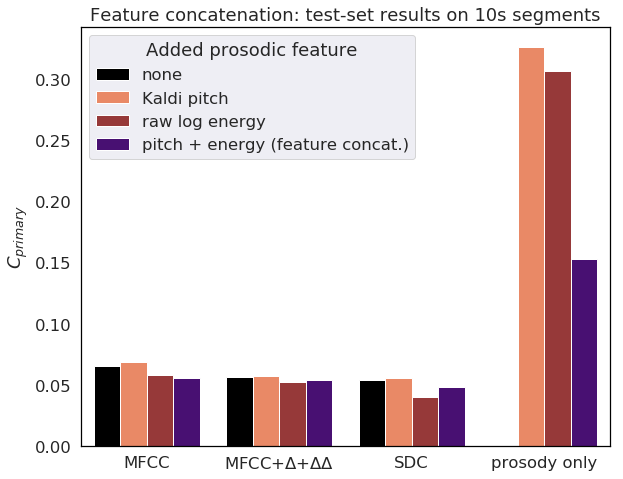

In [13]:
df = pd.read_csv("data/summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test", hue="prosodic", data=df, 
               legend_descs=remove_from_list(prosodic_names, 3), order=acoustic_order, 
               hue_order=remove_from_list(prosodic_order, 3),
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="Feature concatenation: test-set results on 10s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-feature_fusion-10s")

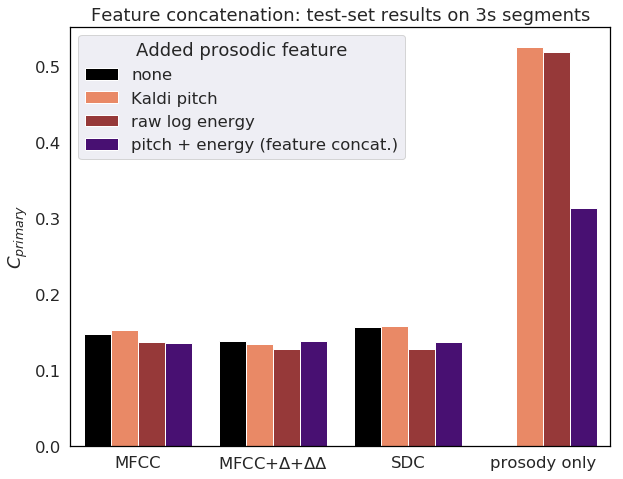

In [14]:
df = pd.read_csv("data/summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test_3s", hue="prosodic", data=df, 
               legend_descs=remove_from_list(prosodic_names, 3), order=acoustic_order, 
               hue_order=remove_from_list(prosodic_order, 3),
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="Feature concatenation: test-set results on 3s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-feature_fusion-3s")

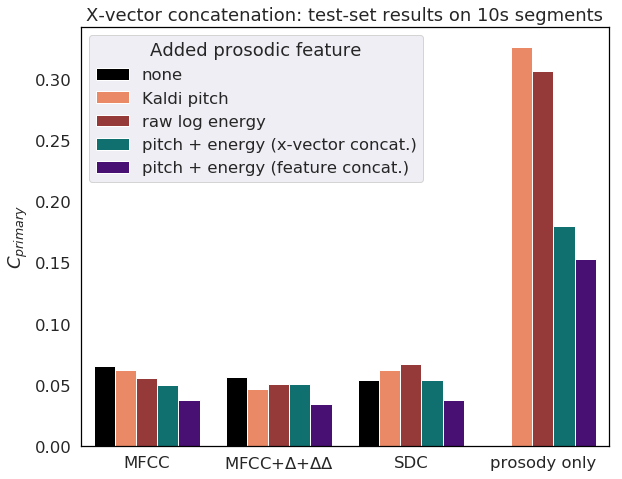

In [15]:
df = pd.read_csv("data/fusion_summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test", hue="prosodic", data=df, 
               legend_descs=prosodic_names, order=acoustic_order, hue_order=prosodic_order, 
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="X-vector concatenation: test-set results on 10s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-xvector_fusion-10s")

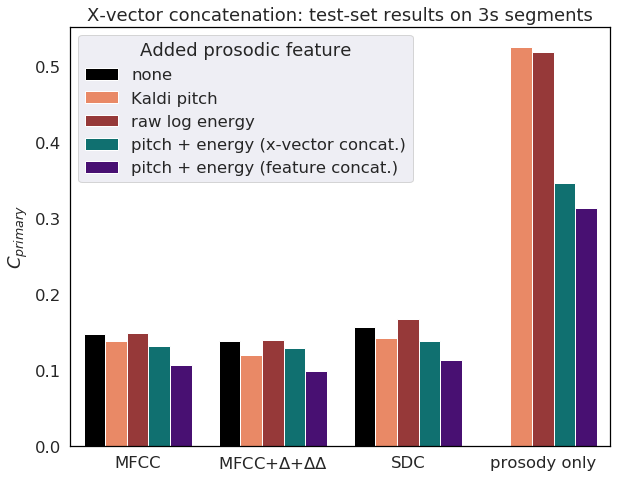

In [16]:
df = pd.read_csv("data/fusion_summary.csv", index_col=None)
fig = graphing.plot_cat(x="acoustic", y="c_prim_test_3s", hue="prosodic", data=df, 
               legend_descs=prosodic_names, order=acoustic_order, hue_order=prosodic_order, 
               palette=prosody_colours, legend_title="Added prosodic feature", 
               title="X-vector concatenation: test-set results on 3s segments", 
               ylabel="$C_{primary}$", xlabel=None, xticks=acoustic_names)

graphing.save_fig(fig, name="summary-xvector_fusion-3s")

## Final confusion matrices

In [21]:
def get_conf_mtrx(exp_name):
    filepath = "data/{}_conf_matrix-eval.csv".format(exp_name)
    mtrx = np.genfromtxt (filepath, delimiter=",", skip_header=1)
    normaliser = np.repeat(mtrx.sum(axis=1), 19).reshape((19,19))
    mtrx_normalised = 100*(np.divide(mtrx, normaliser))
    return mtrx_normalised

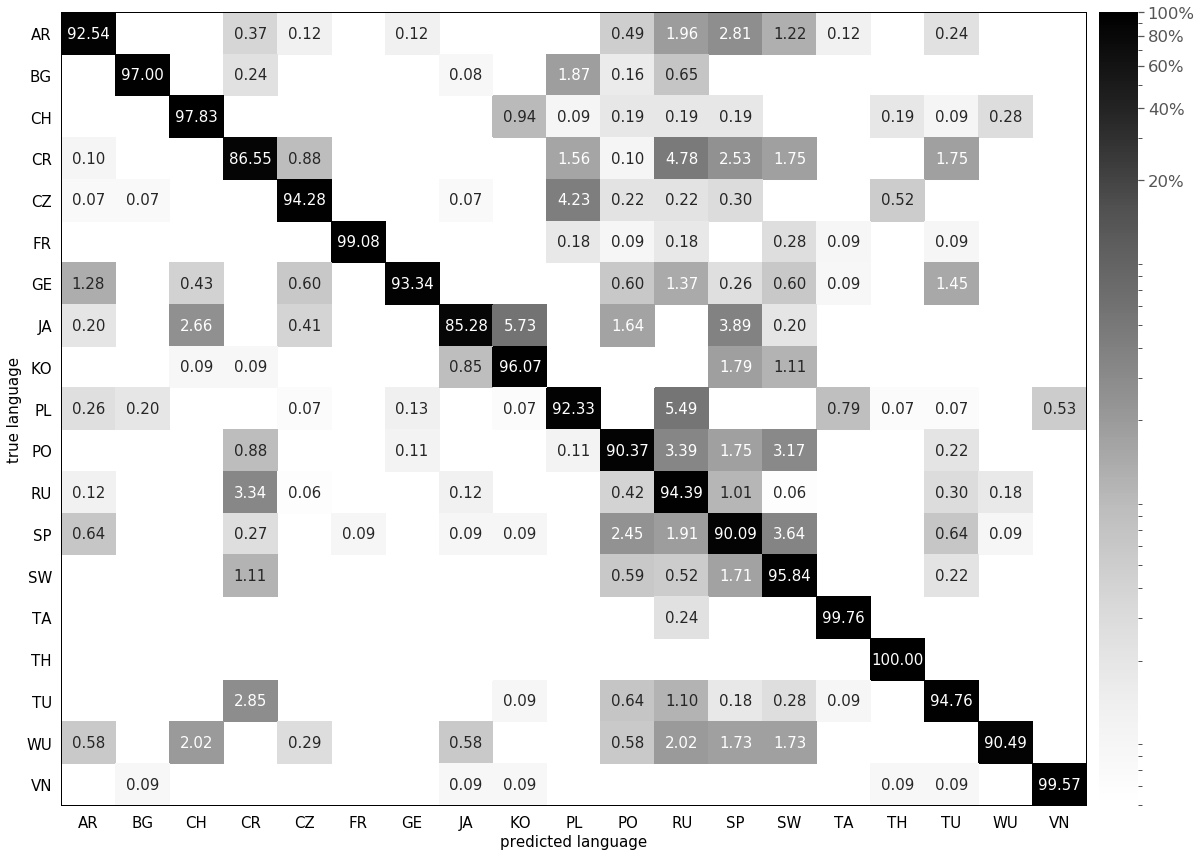

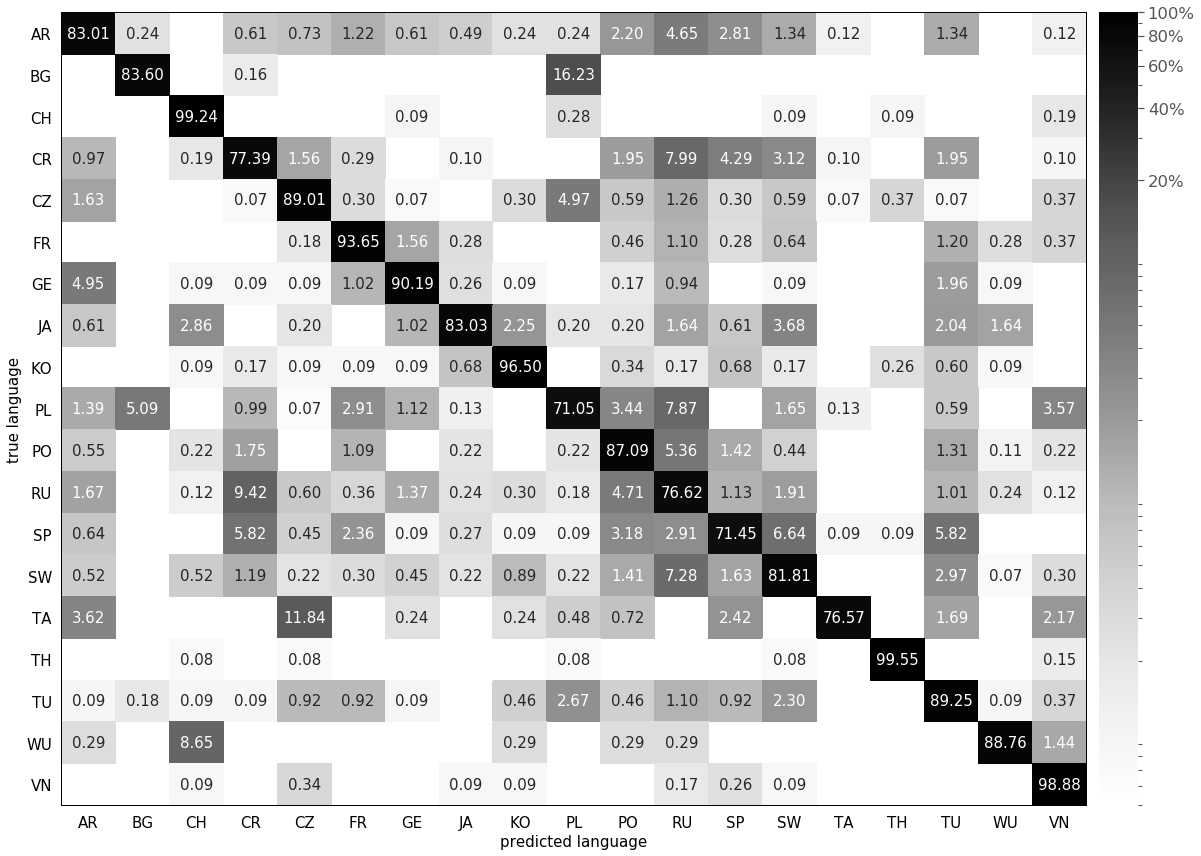

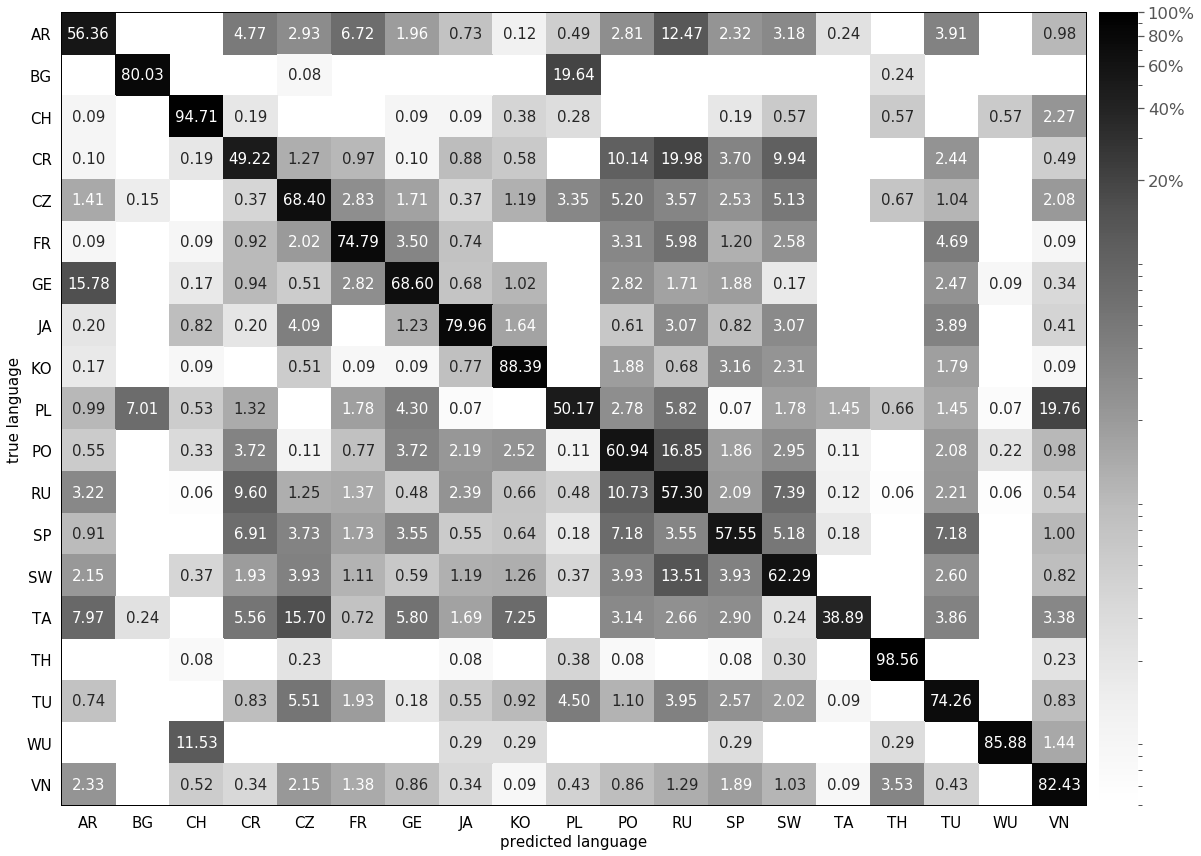

In [26]:
for exp_name in ["mfcc_deltas_pitch_energy", "pitch_energy", "pitch"]:
    mtrx = get_conf_mtrx(exp_name)
    fig = graphing.plot_heatmap(mtrx, ys=languages, xs=languages, y_label="true language", 
                       x_label="predicted language", height=12, width=18, cmap="Greys", logColourbar=True, 
                       scale_format="%.0f%%", min_v=0.05, max_v=100, fmt=".2f")
    graphing.save_fig(fig, name="conf_mtrx_{}".format(exp_name))

## Comparing confusion matrices

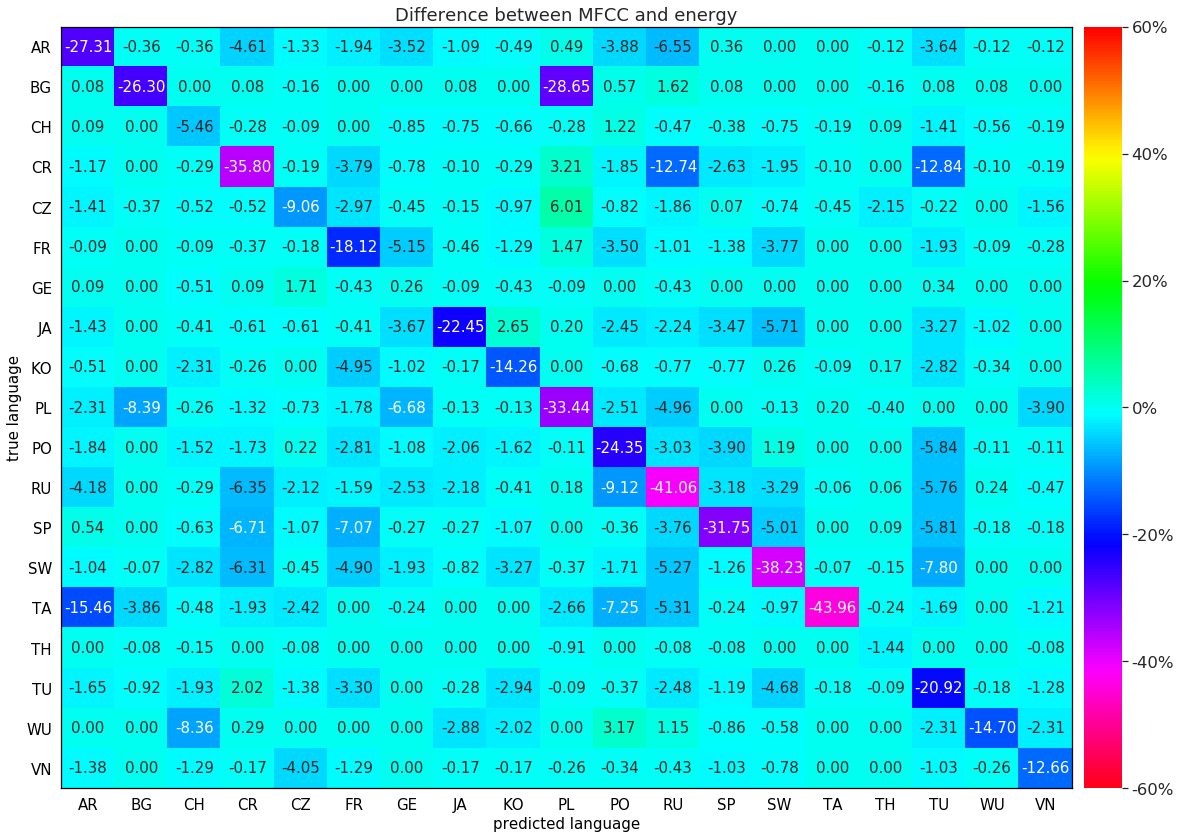

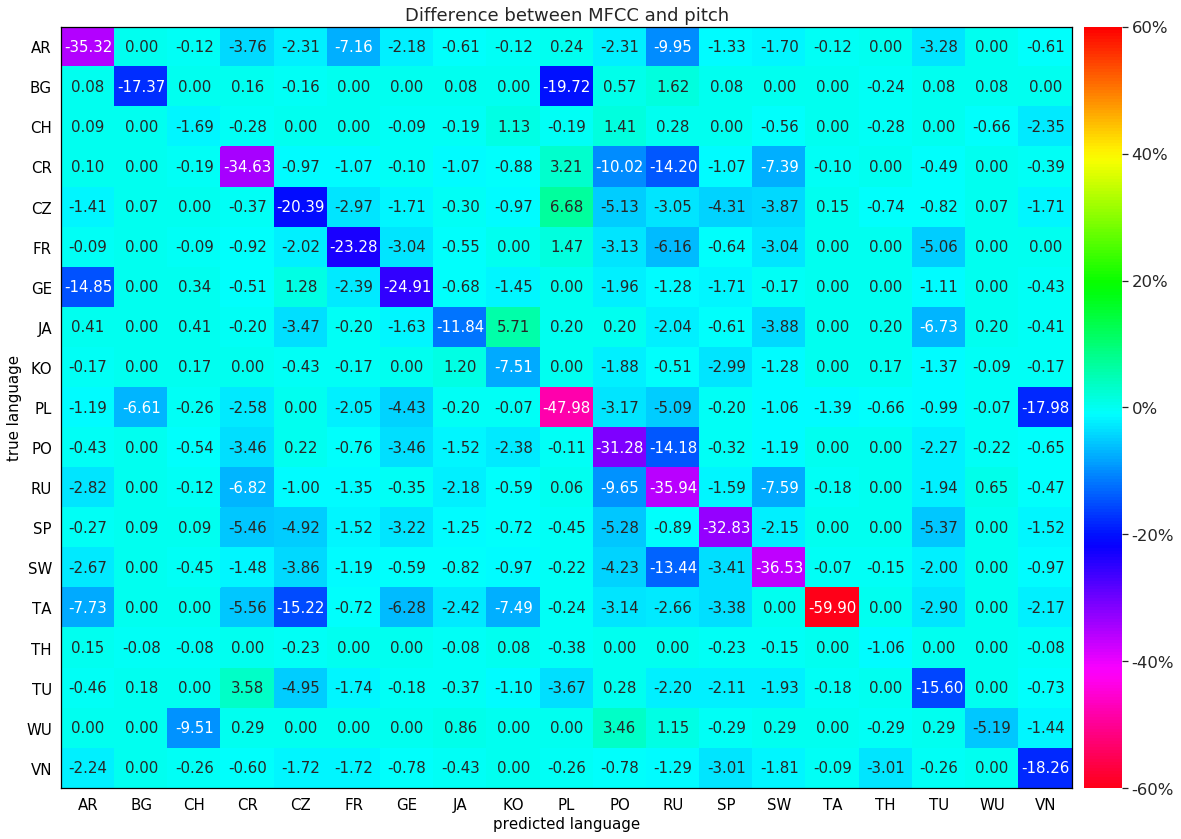

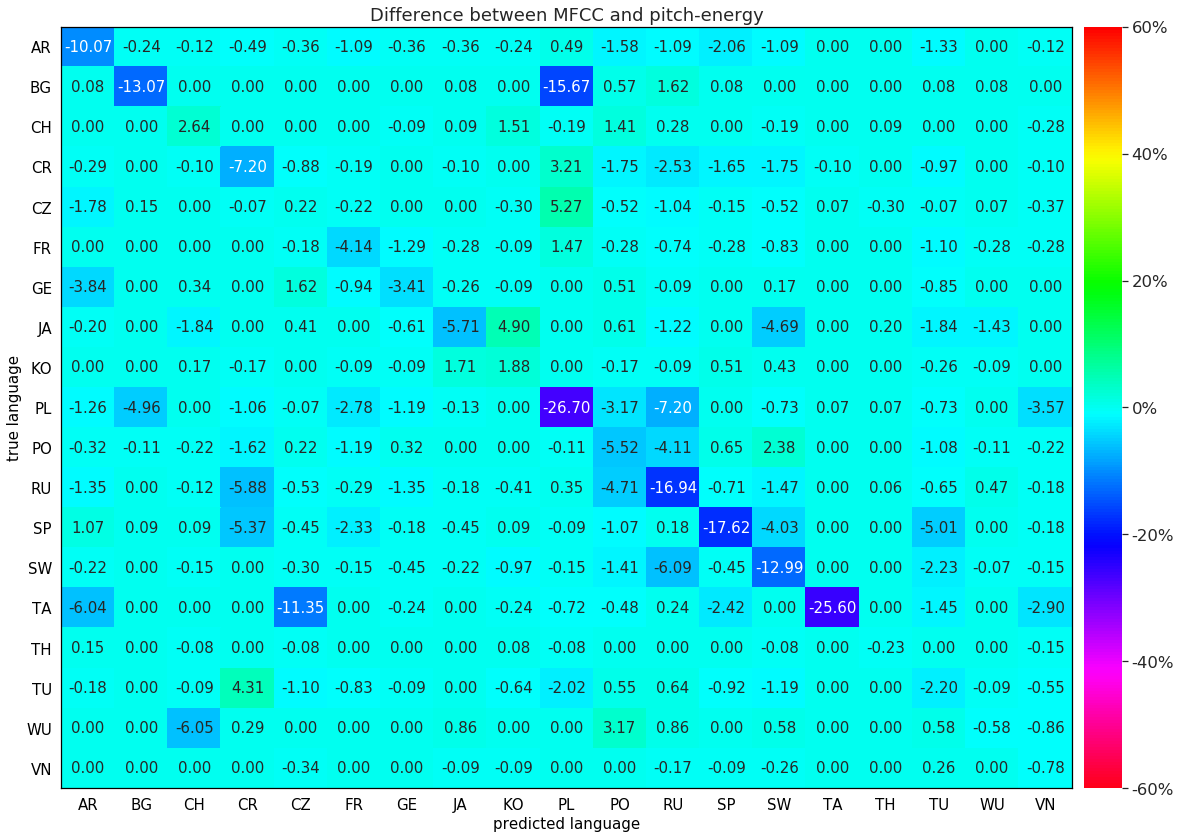

In [55]:
mtrx_mfcc = get_conf_mtrx("mfcc")
diagonal_flipper = np.ones((19,19)) -2 * np.eye(19)

for prosody_exp in ["energy", "pitch", "pitch-energy"]:
    mtrx_prosodic = get_conf_mtrx(prosody_exp)
    mtrx = mtrx_mfcc - mtrx_prosodic
    mtrx = np.multiply(mtrx, diagonal_flipper)
    fig = plot_heatmap(mtrx, ys=languages, xs=languages, y_label="true language", 
                       x_label="predicted language", height=12, width=18, cmap="hsv_r", logColourbar=False, 
                       scale_format="%.0f%%", min_v=-60, max_v=60, fmt=".2f", 
                       title="Difference between MFCC and {}".format(prosody_exp))
    save_fig(fig, "diff_mfcc_{}".format(prosody_exp))

## Log-reg tuning

Let's see the best config overall:

In [9]:
max_steps_vals = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
normalizer_vals = [0, 0.00001, 0.0001, 0.001, 0.01]
mix_up_vals = [19, 50, 100, 150, 200, 250, 300]

# max-steps,normaliser,mix-up,acc,c_prim

file_path = "data/log-reg-gridsearch3D.txt"
grid_search_stats = pd.read_csv(file_path)
c_min = grid_search_stats["c_prim"].min()
c_max = grid_search_stats["c_prim"].max()

best_row_index = grid_search_stats["c_prim"].idxmin()
best_config = grid_search_stats.iloc[best_row_index]
print("Best values:\n{}".format(best_config))

Best values:
max-steps     100.000
normaliser      0.001
mix-up        100.000
acc             0.898
c_prim          0.136
Name: 163, dtype: float64


Okay, so this is the best one. But let's look at it more closely.

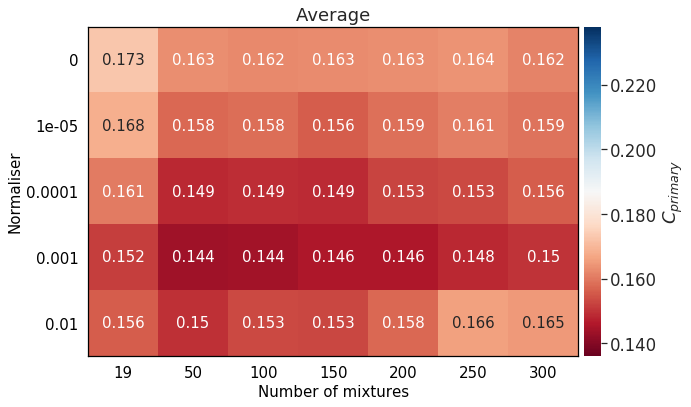

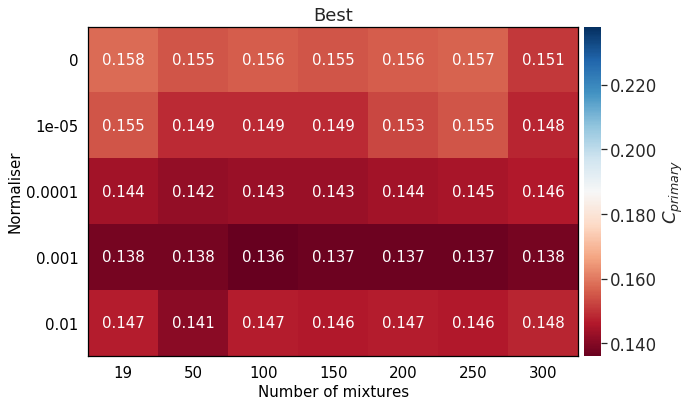

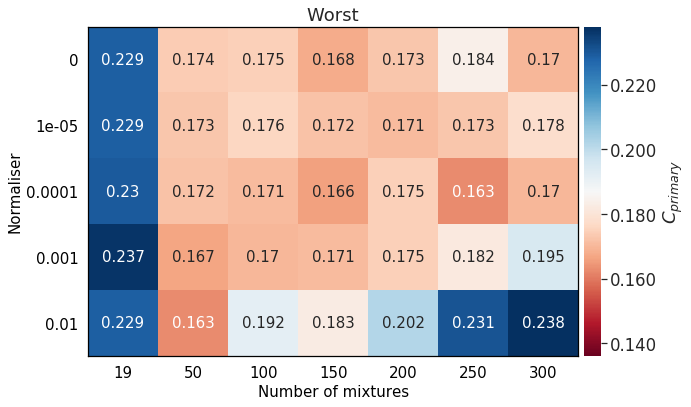

In [10]:
matrices = np.zeros((len(max_steps_vals), len(normalizer_vals), len(mix_up_vals)))

for i, max_step_val in enumerate(max_steps_vals):
    title = "C_primary dependent on normaliser and mix-up values for max-steps = {}".format(max_step_val)
    stats = grid_search_stats[grid_search_stats["max-steps"] == max_step_val]
    matrix = np.array([
                [
                    stats[(stats["mix-up"] == mix_up) & (stats["normaliser"] == norm)]["c_prim"].item()
                    for mix_up in mix_up_vals
                ] 
                for norm in normalizer_vals
             ])
    matrices[i] = matrix
    
fig = plot_heatmap(np.average(matrices, axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Average")
fig = plot_heatmap(matrices.min(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Best")
fig = plot_heatmap(matrices.max(axis=0), ys=normalizer_vals, xs=mix_up_vals, y_label="Normaliser", x_label="Number of mixtures",
             height=6, cmap="RdBu", logColourbar=False, scale_label=r"$C_{primary}$", scale_format="%.3f", 
             min_v=c_min, max_v=c_max, title="Worst")

Okay, looks like normaliser=0.001 is a clear winner. Now what about the other two params?

In [20]:
stats_for_fixed_normaliser = []

for mix_up_val in mix_up_vals:
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & (grid_search_stats["mix-up"] == mix_up_val)]["c_prim"]
    mean = data_points.mean()
    stdev = data_points.std()
    stats_for_fixed_normaliser.append(np.array([mean, stdev]))

    data_line =[{
        "values": np.array(stats_for_fixed_normaliser)[:, 0],
        "xs": mix_up_vals,
        "err_bars": np.array(stats_for_fixed_normaliser)[:, 1],
        "label": None,
        "colour": "black",
        "symbol": "x"
    }]
    
fig = graphing.plot_linear(data_line, x_label="Number of mixtures", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(8, 6),
                ymin=None, ymax=None, use_legend=False)

NameError: name 'mix_up_vals' is not defined

Cool, looks like numer of mixtures could be 50 or 100.

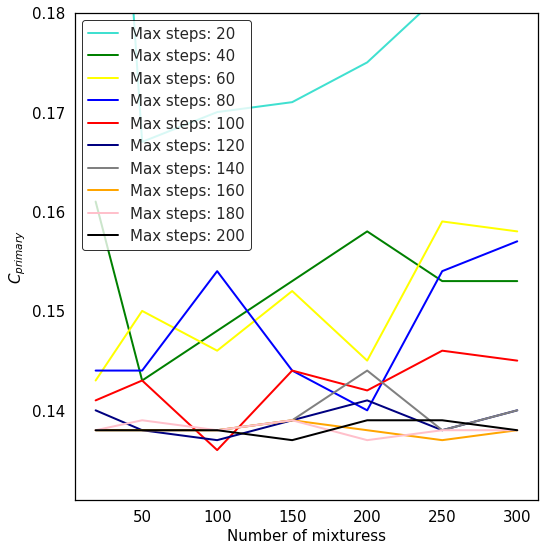

In [12]:
data_line = []
colours = ['turquoise', 'green', 'yellow', 'blue', 'red', 'navy', 'gray', 'orange', 'pink', 'black']
for i, max_steps_val in enumerate(max_steps_vals):
    data_points = grid_search_stats[(grid_search_stats["normaliser"] == 0.001) & (grid_search_stats["max-steps"] == max_steps_val)]["c_prim"]
    data_line.append({
        "values": data_points,
        "xs": mix_up_vals,
        "label": "Max steps: {}".format(max_steps_val),
        "colour": colours[i],
    })

fig = graphing.plot_linear(data_line, x_label="Number of mixturess", y_label="$C_{primary}$", 
                legend_loc=0, mark_maxima=False, axis_scales="normal", figsize=(8, 8),
                ymin=None, ymax=0.18, linewidth=2)

It's clear now that the more steps, the more stable curve. That's what we want. Let's go with max-steps=200. And number of mixtures doesn't seem to matter too much, so let's use the smallest value that gives good results for high numbers of steps. That's 100.

To recap: `normaliser=0.001, max-steps=200, mix-up=100`.

## TDNN training epochs tuning

3-epoch training on its own took 8h11min=8.18333h (for 70 iterations), which gives slightly over 7min/iteration (precisely, 7.0142857min).

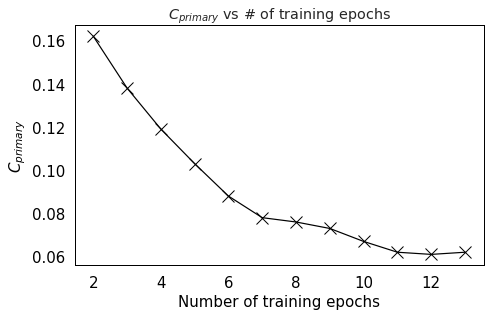

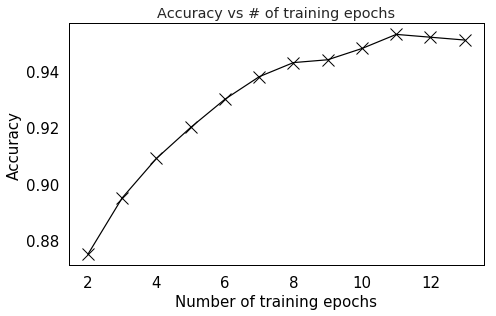

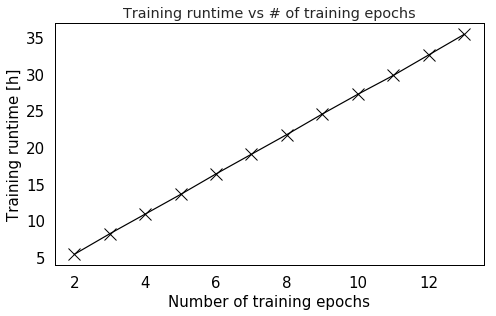

In [30]:
epochs_vals = list(range(2, 14))

# epochs,acc,c_prim,num_iters
file_path = "data/dnn-num-epochs-search.txt"
stats = pd.read_csv(file_path)

data_line =[{
    "values": stats["c_prim"],
    "xs": stats["epochs"],
    "label": None,
    "colour": "black",
    "symbol": "x"
}]

fig = graphing.plot_linear(data_line, x_label="Number of training epochs", y_label="$C_{primary}$", 
                legend_loc=0, figsize=(7, 4.5), ymin=None, ymax=None, use_legend=False, 
                title="$C_{primary}$ vs # of training epochs")
graphing.save_fig(fig=fig, name="num-epochs_c-primary")

data_line =[{
    "values": stats["acc"],
    "xs": stats["epochs"],
    "label": None,
    "colour": "black",
    "symbol": "x"
}]

fig = graphing.plot_linear(data_line, x_label="Number of training epochs", y_label="Accuracy", 
                legend_loc=0, figsize=(7, 4.5), ymin=None, ymax=None, use_legend=False,
                title="Accuracy vs # of training epochs")
graphing.save_fig(fig=fig, name="num-epochs_accuracy")

data_line =[{
    "values": stats["num_iters"]*7.0142857/60,
    "xs": stats["epochs"],
    "label": None,
    "colour": "black",
    "symbol": "x"
}]

fig = graphing.plot_linear(data_line, x_label="Number of training epochs", y_label="Training runtime [h]", 
                legend_loc=0, figsize=(7, 4.5), ymin=None, ymax=None, use_legend=False,
                title="Training runtime vs # of training epochs")
graphing.save_fig(fig=fig, name="num-epochs_runtime")